# Full Bayesian inference using linear approximation of dynamics

In [95]:
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint

from gMLV import *

def set_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)

# some plotting functions

cols = ["red", "green", "blue", "royalblue","orange", "black", "salmon", "forestgreen", "steelblue", "slateblue","gold", "palegreen"]

def plot_gMLV(yobs, sobs, timepoints):
    #fig, axs = plt.subplots(1, 2, layout='constrained')
    fig, axs = plt.subplots(1, 2)
    for species_idx in range(yobs.shape[1]):
        axs[0].plot(timepoints, yobs[:, species_idx], color=cols[species_idx])
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('[species]')
    if sobs.shape[1] > 0:
        for metabolite_idx in range(sobs.shape[1]):
            axs[1].plot(timepoints, sobs[:, metabolite_idx], color=cols[metabolite_idx])
        axs[1].set_xlabel('time')
        axs[1].set_ylabel('[metabolite]');

def plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, timepoints):
    # plot the fit
    #fig, axs = plt.subplots(1, 2, layout='constrained')
    fig, axs = plt.subplots(1, 2)  
    for species_idx in range(yobs.shape[1]):
        axs[0].plot(timepoints, yobs[:, species_idx], color=cols[species_idx])
        axs[0].plot(timepoints, yobs_h[:, species_idx], '--', color=cols[species_idx])
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('[species]');

    for metabolite_idx in range(sobs.shape[1]):
        axs[1].plot(timepoints, sobs[:, metabolite_idx], color=cols[metabolite_idx])
        axs[1].plot(timepoints, sobs_h[:, metabolite_idx], '--', color=cols[metabolite_idx])
    axs[1].set_xlabel('time')
    axs[1].set_ylabel('[metabolite]');

def compare_params(mu=None, M=None, alpha=None, e=None):
    # each argument is a tuple of true and predicted values
    if mu is not None:
        print("mu_hat/mu:")
        print(np.array(mu[1]))
        print(np.array(mu[0]))

        fig, ax = plt.subplots()
        ax.stem(np.arange(0,len(mu[0]), dtype="int32"), np.array(mu[1]), markerfmt="D")
        ax.stem(np.arange(0,len(mu[0]), dtype="int32"), np.array(mu[0]), markerfmt="X")
        ax.set_xlabel('i')
        ax.set_ylabel('mu[i]');

    if M is not None:
        print("\nM_hat/M:")
        print(np.round(np.array(M[1]), decimals=2))
        print("\n",np.array(M[0]))

        #fig, ax = plt.subplots()
        #ax.stem(np.arange(0, M[0].shape[0] ** 2), np.array(M[1]).flatten(), markerfmt="D")
        #ax.stem(np.arange(0, M[0].shape[0] ** 2), np.array(M[0]).flatten(), markerfmt="X")
        #ax.set_ylabel('M[i,j]');

        fig, ax = plt.subplots()
        Ns = M[0].shape[0]
        ax.stem(np.arange(0, Ns), np.array(M[1]).diagonal(), markerfmt="D")
        ax.stem(np.arange(0, Ns), np.array(M[0]).diagonal(), markerfmt="X")
        ax.set_ylabel('M[i,i]');
        
        fig, ax = plt.subplots()
        Ns = M[0].shape[0]
        
        count = 0
        Mij = np.zeros([Ns*Ns - Ns])
        Mij_h = np.zeros([Ns*Ns - Ns])
        for i in range(Ns):
            for j in range(Ns):
                if i != j:
                    Mij[count] = np.array(M[0])[i,j]
                    Mij_h[count] = np.array(M[1])[i,j]
                    count = count + 1
        
        ax.stem(np.arange(0, Ns*Ns - Ns), Mij.flatten(), markerfmt="D")
        ax.stem(np.arange(0, Ns*Ns - Ns), Mij_h.flatten(), markerfmt="X")
        ax.set_ylabel('M[i,i]');
        
    if alpha is not None:
        print("\na_hat/a:")
        print(np.round(np.array(alpha[1]), decimals=2))
        print("\n",np.array(alpha[0]))

        fig, ax = plt.subplots()
        ax.stem(np.arange(0, alpha[0].shape[0] * alpha[0].shape[1]), np.array(alpha[1]).flatten(), markerfmt="D")
        ax.stem(np.arange(0, alpha[0].shape[0] * alpha[0].shape[1]), np.array(alpha[0]).flatten(), markerfmt="X")
        ax.set_ylabel('a[i,j]');

    if e is not None:
        print("\ne_hat/e:")
        print(np.round(np.array(e[1]), decimals=2))
        print("\n",np.array(e[0]))

        fig, ax = plt.subplots()
        ax.stem(np.arange(0, e[0].shape[0]), np.array(e[1]).flatten(), markerfmt="D")
        ax.stem(np.arange(0, e[0].shape[0]), np.array(e[0]).flatten(), markerfmt="X")
        ax.set_ylabel('e[i]');

def print_params(mu=None, M=None, e=None):
    # each argument is a tuple of true and predicted values
    if mu is not None:
        print("mu_hat:")
        print(np.array(mu))

        fig, ax = plt.subplots()
        ax.stem(np.arange(0,len(mu), dtype="int32"), np.array(mu), markerfmt="X")
        ax.set_xlabel('i')
        ax.set_ylabel('mu[i]');

    if M is not None:
        print("\nM_hat:")
        print(np.round(np.array(M), decimals=2))

        fig, ax = plt.subplots()
        Ns = M.shape[0]
        ax.stem(np.arange(0, Ns), np.array(M).diagonal(), markerfmt="X")
        ax.set_ylabel('M[i,i]');
        
        fig, ax = plt.subplots()
        Ns = M.shape[0]
        
        count = 0
        Mij_h = np.zeros([Ns*Ns - Ns])
        for i in range(Ns):
            for j in range(Ns):
                if i != j:
                    Mij_h[count] = np.array(M)[i,j]
                    count = count + 1
        
        ax.stem(np.arange(0, Ns*Ns - Ns), Mij_h.flatten(), markerfmt="X")
        ax.set_ylabel('M[i,i]');
    
    if e is not None:
        print("\ne_hat:")
        print(np.round(np.array(e), decimals=2))

        fig, ax = plt.subplots()
        ax.stem(np.arange(0, e.shape[0]), np.array(e).flatten(), markerfmt="X")
        ax.set_ylabel('e[i]');


# some MCMC analysis functions

def make_trace_plot(var,istart,iend):
    plt.figure()
    post = df[var][istart:iend]
    plt.plot(range(0,(iend-istart)),post)
    #print(var, np.median(post))
    return
    
def make_hist_plot(var,istart,iend):
    plt.figure()
    post = df[var][istart:iend]
    plt.hist(post)
    print(var, np.median(post))
    return
    
def get_Rhat(N,p1,p2):
    M = 2
    mean1 = np.mean(p1,axis=0)  
    mean2 = np.mean(p2,axis=0)  
    var1 = np.var(p1,axis=0)  
    var2 = np.var(p2,axis=0)
    
    meanM = (1/M)*(mean1 + mean2)
    
    B = (N/(M-1)) * (mean1-meanM)*(mean1-meanM) + (mean2-meanM)*(mean2-meanM)
    W = (1/M)*(var1 + var2)
    
    Vhat = ((N-1)/N)*W + ((M+1)/(M*N))*B
    
    Rhat = Vhat/W
    
    return Rhat

def get_horseshoe_tau(p0,D,sigma,n):
    return p0*sigma/( np.sqrt(n)*(D-p0) )

# extract gLV vectors and matrix from posterior sample
def extract_gLV_pars(est, num_species, e=False):

    # fill mu_h
    #mu_h = mu # if mu is fixed
    mu_h = est[0:num_species]
    est = est[num_species:]

    # fill M_h
    M_h = np.zeros([num_species,num_species])
    #np.fill_diagonal(M_h, M.diagonal() ) # if Md fixed
    np.fill_diagonal(M_h, -est[0:num_species])
    est = est[num_species:]

    count = 0
    #print("est:", est)
    for i in range(num_species):
        for j in range(num_species):
            if i != j:
                #M_h[i,j] = est[2*num_species + count]
                #M_h[i,j] = est[num_species + count]
                M_h[i,j] = est[count]
                count = count + 1

    #print(mu_h)
    #print(M_h)
    
    if e==False:
        return mu_h, M_h
    else:
        est = est[num_species*(num_species-1):]
        E_h = np.reshape(est[0:num_species],(num_species,1))

        return mu_h, M_h, E_h

def get_signal_matrix(npert, tp):
    # calculate signal matrix
    u = np.zeros([npert,len(times)])
    for i in range(npert):
        ui = (times >= tp[i][0]) & (times <= tp[i][1]) 
        u[i,:] = ui

    # remove last column of signal matrix
    u = u[:,:(u.shape[1]-1)]
    print('signal matrix:\n', u)
    return u
 
def visualise_chains():
    print("mu:",mu)
    for i in range(num_species):
        make_trace_plot("mu."+str(i+1),istart,iend)
        make_hist_plot("mu."+str(i+1),istart,iend)

    print("Md:",M.diagonal())
    for i in range(num_species):
        make_trace_plot("Md."+str(i+1),istart,iend)
        make_hist_plot("Md."+str(i+1),istart,iend)

    for i in range( num_species*(num_species - 1)):
        make_trace_plot("M."+str(i+1),istart,iend)
        make_hist_plot("M."+str(i+1),istart,iend)



In [ ]:
   
set_all_seeds(1234)

In [ ]:
# Prior visualisation
# mu
x_mu = np.random.lognormal(0.01,0.5,size=10000)
plt.figure()
plt.hist(x_mu);
plt.title('mu')   

# Md
x_Md = np.random.normal(0.1,0.05,size=10000)
plt.figure()
plt.hist(x_Md);
plt.title('M[i,i]')    
    
# Shrinkage, M
tau0 = 0.001;
x_M = np.zeros([1000])
for i in range(1000):
    tau = np.random.standard_cauchy(size=1)
    lam = np.random.standard_cauchy(size=1)
    x_M[i] = np.random.normal(0,np.abs(lam)*np.abs(tau),size=1)
#print(x_M)
plt.figure()
plt.hist(x_M, range=(-5,5));
plt.title('M[i,j]');   

# sigma
x_sig = np.random.lognormal(0.01,0.5,size=10000)
plt.figure()
plt.hist(x_sig);
plt.title('sigma')  

## M40 (no perturbations)

times:
 [30 31 33 35 37 38 39 40 42]
data:
 [[ 913  487  328  150   10]
 [ 901  476  354  119   28]
 [ 438 1117  229  162   39]
 [ 718  672  366  109    1]
 [ 614   83  352  297   53]
 [  80  475   71   52    1]
 [ 138  136   34   51   28]
 [ 376  185  189  273  166]
 [ 935  399  363  309   85]]
[[-0.01323062 -0.02284627  0.0762833  -0.2315118   1.02961942]
 [-0.36064317  0.42649197 -0.21778745  0.15423642  0.16567857]
 [ 0.24712533 -0.25407173  0.23445566 -0.19812423 -1.83178082]
 [-0.07823732 -1.04570887 -0.01950108  0.50119213  1.98514596]
 [-2.03796829  1.7444742  -1.6009513  -1.74248842 -3.97029191]
 [ 0.54522705 -1.25065992 -0.73631935 -0.01941809  3.33220451]
 [ 1.00233546  0.30770094  1.71538649  1.67764616  1.77978328]
 [ 0.45547869  0.3843028   0.32632791  0.06193474 -0.33466827]]
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/d0/x63k438154b57fhf8cw2n7n00000gn/T/httpstan_w4r1u8s7/model_xoj2odmz.stan', line 2, column 30: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/var/folders/d0/x63k438154b57fhf8cw2n7n00000gn/T/httpstan_wf0vpve2/model_xoj2odmz.stan', line 71, column 8 to column 56)
  If this warning occurs sporadically, such

Rhat: [0.9980804  0.99857661 0.99802654 0.99884519 0.99824064 0.99838109
 0.99806782 1.00395741 1.00039643 0.99826536 0.99804891 0.99818371
 0.99838982 0.99823543 0.9984946  0.99834582 0.99865204 0.99985983
 1.00270325 0.99917551 1.00160294 1.0029916  0.99901452 1.00049744
 0.99805511 0.99991686 1.00143773 0.99814861 1.0002578  0.99916343
 1.00925562 0.99968967 1.00072863 0.99943542 0.99967938 1.00102487
 0.99880141 0.9998362  0.99893483 0.99812475 0.99944219 1.00808369
 0.99858138 1.00250601 0.99800051 1.00138798 1.00091845 1.00172904
 0.99870135 1.00238955 0.99801211]
mu_hat:
[1.01236453 0.13451248 0.7195176  1.37896617 4.18561414]

M_hat:
[[-0.    0.   -0.   -0.01  0.01]
 [ 0.   -0.   -0.01  0.01 -0.01]
 [ 0.    0.   -0.01 -0.01  0.01]
 [ 0.   -0.    0.   -0.01  0.02]
 [ 0.   -0.   -0.   -0.02 -0.  ]]


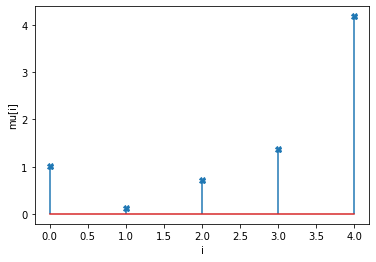

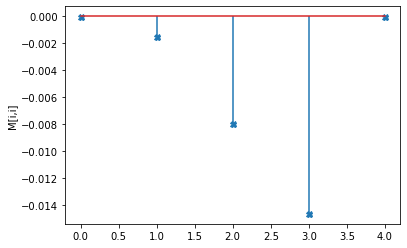

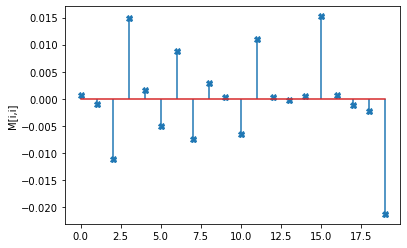

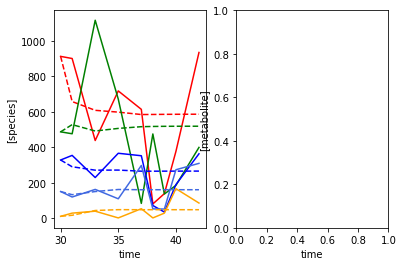

In [133]:
# Read in data
data = pd.read_csv("maria_multiomics/processed/data-top5-M40.csv")
times = data.iloc[:,0].to_numpy()
print("times:\n",times)
yobs = data.drop(columns=['timepoint', 'subjectID']).to_numpy()
yobs[yobs == 0] = 1

#print(data)
print("data:\n",yobs)

num_species=5

# linearise
X, F = linearize_time_course_16S(yobs, times)

#print(X[:,:(X.shape[1]-1)])
X = X[:,:(X.shape[1]-1)]
#print(F)

import nest_asyncio
nest_asyncio.apply()
import stan

f = open("model_nopert.txt", "r")
gLV_code=f.read()

obs_data_lin = {"N": 5,
                "T": len(times)-1,   
                "y": F,
                "x": X,
                "tau0": 0.01,
                "sigma": 0.1,
                } 

posterior = stan.build(gLV_code, data=obs_data_lin, random_seed=1)

sample_kwargs = {"num_samples": 1000, "num_chains": 2, "num_warmup": 5000 }
#fit = posterior.sample(num_chains=2, num_samples=500, num_warmup=10000, adapt={'delta':0.99})
fit = posterior.sample(**sample_kwargs);

#print(fit)

df = fit.to_frame()
#print(df.describe().T)
#print(df.head())

post1 = df[df.columns[7:]][0:500].to_numpy()
post2 = df[df.columns[7:]][500:1000].to_numpy()
Rhat = get_Rhat(500, post1, post2)
print("Rhat:", Rhat)
istart = 0
iend = 2000

# plot the fit using median values of parameters
post1 = df[df.columns[7:]][0:iend].to_numpy()
est = np.median(post1,axis=0)
    
mu_h, M_h = extract_gLV_pars(est, num_species)
    
print_params(mu=mu_h, M=M_h)

# make the plot and comparison
predictor = gMLV_sim(num_species=num_species,
                     num_metabolites=0,
                     M=M_h,
                     mu=mu_h)

init_species = yobs[0,:]

yobs_h, sobs_h, _, _, _, _ = predictor.simulate(times=times, sy0=np.hstack((init_species, init_metabolites)))

## PLOT RESULTS
# plot comparison of simulated and predicted timeseries
plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, times)

## Q160 (no perturbations)

times:
 [ 7 10 13 15 16 17 20 21]
data:
 [[1266  734  270  300  120]
 [ 730   58 1002   26   79]
 [ 905  964  282  147    1]
 [ 460  189  114  304    1]
 [ 698  733   82   71   11]
 [1026  666  119  313  136]
 [ 328  451  870  644   87]
 [1124 1499  526  186  104]]
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/d0/x63k438154b57fhf8cw2n7n00000gn/T/httpstan_w4r1u8s7/model_xoj2odmz.stan', line 2, column 30: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Sampling:   0%
Sampling:   2% (200/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sampling:  18% (2200/12000)
Sampling:  19% (2300/12000)
Sampling:  20% (2400/120

Rhat: [0.99803663 1.00070672 0.99847608 1.00446867 1.00039549 0.99873305
 0.99952597 0.99814169 1.00794453 1.00131665 0.99861479 0.9986288
 0.99833405 0.99807707 1.00329757 0.99894313 0.99857401 1.00046816
 0.99934043 0.99808731 0.99829406 0.99804577 1.00512459 0.99886549
 1.00002273 1.00521472 1.00000243 0.99928605 1.00184184 0.9995111
 1.00205641 0.99806622 1.00022101 0.99801024 1.00146293 1.00099844
 1.0006223  1.00016948 1.01461538 1.00369942 0.99957344 1.00688121
 0.99825736 1.01193728 1.02212887 1.00576483 0.99821847 0.99860299
 1.00158186 1.00148755 0.99806781]
mu_hat:
[0.90408757 2.41715669 0.60881918 2.54980862 4.36395829]

M_hat:
[[-0.    0.    0.    0.    0.  ]
 [-0.   -0.   -0.    0.    0.  ]
 [-0.    0.   -0.   -0.    0.01]
 [-0.    0.   -0.   -0.01  0.02]
 [-0.   -0.   -0.   -0.   -0.  ]]


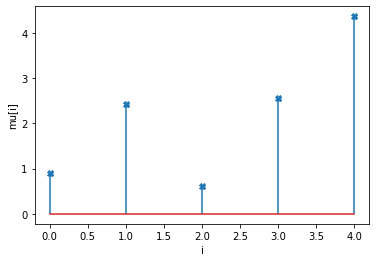

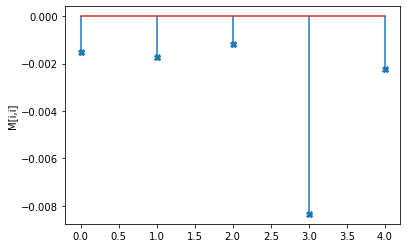

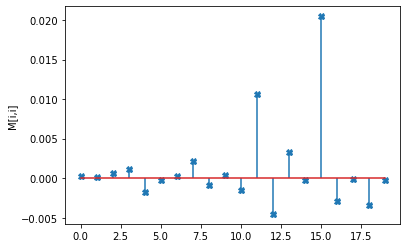

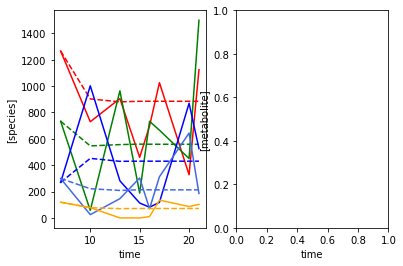

In [109]:
# Read in data
data = pd.read_csv("maria_multiomics/processed/data-top5-Q160.csv")
times = data.iloc[:,0].to_numpy()
print("times:\n",times)
yobs = data.drop(columns=['timepoint', 'subjectID']).to_numpy()
yobs[yobs == 0] = 1

#print(data)
print("data:\n",yobs)

num_species=5

# linearise
X, F = linearize_time_course_16S(yobs, times)

#print(X[:,:(X.shape[1]-1)])
X = X[:,:(X.shape[1]-1)]

import nest_asyncio
nest_asyncio.apply()
import stan

f = open("model_nopert.txt", "r")
gLV_code=f.read()

obs_data_lin = {"N": 5,
                "T": len(times)-1,   
                "y": F,
                "x": X,
                "sigma": 0.01,
                "tau0": 0.01,
                } 

posterior = stan.build(gLV_code, data=obs_data_lin, random_seed=1)

sample_kwargs = {"num_samples": 1000, "num_chains": 2, "num_warmup": 5000 }
#fit = posterior.sample(num_chains=2, num_samples=500, num_warmup=10000, adapt={'delta':0.99})
fit = posterior.sample(**sample_kwargs);

#print(fit)

df = fit.to_frame()
#print(df.describe().T)
#print(df.head())

post1 = df[df.columns[7:]][0:500].to_numpy()
post2 = df[df.columns[7:]][500:1000].to_numpy()
Rhat = get_Rhat(500, post1, post2)
print("Rhat:", Rhat)
istart = 0
iend = 2000

# plot the fit using median values of parameters
post1 = df[df.columns[7:]][0:iend].to_numpy()
est = np.median(post1,axis=0)
    
mu_h, M_h = extract_gLV_pars(est, num_species)
    
print_params(mu=mu_h, M=M_h)

# make the plot and comparison
predictor = gMLV_sim(num_species=num_species,
                     num_metabolites=0,
                     M=M_h,
                     mu=mu_h)

init_species = yobs[0,:]

yobs_h, sobs_h, _, _, _, _ = predictor.simulate(times=times, sy0=np.hstack((init_species, init_metabolites)))

## PLOT RESULTS
# plot comparison of simulated and predicted timeseries
plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, times)



## M114 (w perturbation)

times:
 [15 20 21 22 23 24 27]
data:
 [[   1   23  109  674  587]
 [ 296  529  380  347   48]
 [ 454  583   98  337  115]
 [1003  512  229  270  132]
 [1261  284  314  102    1]
 [1089  701  285    1   64]
 [ 763  733 1357   53  141]]
signal matrix:
 [[1. 1. 1. 1. 1. 0.]]
Building...



Building: 17.0s, done.Messages from stanc:
Warning in '/var/folders/d0/x63k438154b57fhf8cw2n7n00000gn/T/httpstan_an32gqrc/model_pkasf7cj.stan', line 3, column 30: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Sampling:   0%
Sampling:   1% (100/12000)
Sampling:   2% (300/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sampling:  18% (2200/12000)
Samplin

Rhat: [0.99876668 0.99900488 0.99800065 1.00022466 0.99984688 0.99802455
 1.0044955  0.99839998 0.9982104  0.99992962 0.99803552 1.00237356
 0.99802252 0.99803186 1.00037448 0.99845672 1.003658   1.00878352
 0.99812803 0.99850565 1.00051766 1.00100669 0.99826177 0.99801128
 0.99992953 0.99825054 0.99860688 1.0003836  1.0026312  0.99882343
 0.99823424 1.01216867 1.00162423 0.99821909 0.99947266 0.99920428
 0.9980007  0.99835299 0.99986215 0.99859822 1.00406622 0.99851407
 0.9980063  0.99966219 0.99821513 1.00005278 0.9992542  0.99803832
 0.9994907  1.00422157 1.00155384 0.99973616 0.99919505 1.00340054
 0.99883713 0.9986579 ]
mu_hat:
[ 0.93536792  4.25883251  1.39317893  0.30520614 35.15624319]

M_hat:
[[-0.    0.   -0.    0.    0.  ]
 [-0.   -0.   -0.   -0.   -0.  ]
 [ 0.    0.   -0.01 -0.    0.  ]
 [-0.    0.01  0.   -0.01  0.01]
 [-0.01 -0.02 -0.01 -0.04 -0.01]]

e_hat:
[[ 0.13]
 [ 0.02]
 [-0.36]
 [-0.89]
 [-0.04]]


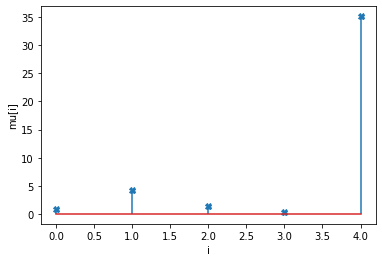

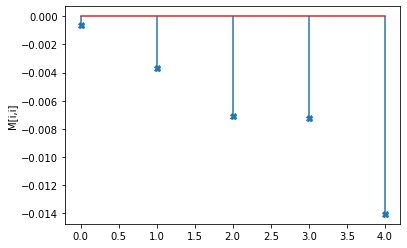

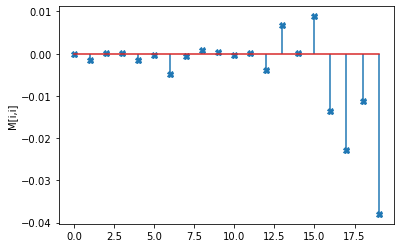

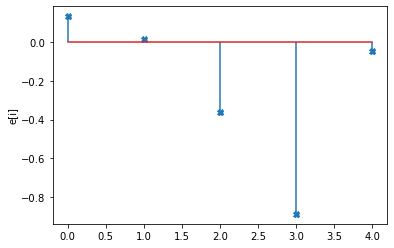

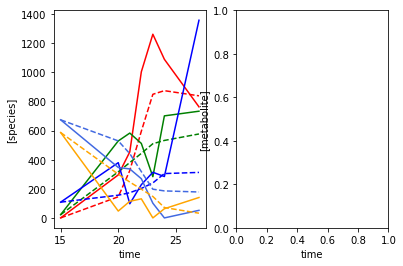

In [110]:
# Read in data
num_species=5

data = pd.read_csv("maria_multiomics/processed/data-top5-M114.csv")
npert = 1
tp = [[15, 23]]

times = data.iloc[:,0].to_numpy()
print("times:\n",times)
yobs = data.drop(columns=['timepoint', 'subjectID']).to_numpy()
yobs[yobs == 0] = 1

print("data:\n",yobs)

u = get_signal_matrix(npert, tp)

# linearise
X, F = linearize_time_course_16S(yobs, times)

#print(X[:,:(X.shape[1]-1)])
X = X[:,:(X.shape[1]-1)]

import nest_asyncio
nest_asyncio.apply()
import stan

f = open("model_pert.txt", "r")
gLV_code=f.read()

obs_data_lin = {"N": num_species,
                "T": len(times)-1,   
                "Np": 1,
                "y": F,
                "x": X,
                "u": u.T,
                "sigma": 0.1,
                "tau0": 0.01,
                } 

posterior = stan.build(gLV_code, data=obs_data_lin, random_seed=1)

sample_kwargs = {"num_samples": 1000, "num_chains": 2, "num_warmup": 5000 }
#fit = posterior.sample(num_chains=2, num_samples=500, num_warmup=10000, adapt={'delta':0.99})
fit = posterior.sample(**sample_kwargs);

#print(fit)

df = fit.to_frame()
#print(df.describe().T)
#print(df.head())

post1 = df[df.columns[7:]][0:500].to_numpy()
post2 = df[df.columns[7:]][500:1000].to_numpy()
#post1 = np.random.normal(size=500)
#post2 = np.random.normal(size=500)
Rhat = get_Rhat(500, post1, post2)
print("Rhat:", Rhat)
istart = 0
iend = 2000

# plot the fit using median values of parameters

post1 = df[df.columns[7:]][0:iend].to_numpy()
est = np.median(post1,axis=0)

mu_h, M_h, E_h = extract_gLV_pars(est, num_species, e=True)

    
print_params(mu=mu_h, M=M_h, e=E_h)

init_species = yobs[0,:]

# make the plot and comparison
predictor = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     num_perturbations=1,
                     M=M_h,
                     mu=mu_h,
                     epsilon=E_h)
yobs_h, sobs_h, _, _, _, _ = predictor.simulate(times=times, sy0=np.hstack((init_species, init_metabolites)), tp=tp)

## PLOT RESULTS
# plot comparison of simulated and predicted timeseries
plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, times)


## Q99 (w single perturbation)

times:
 [15 19 23 26 29 31 34 35]
data:
 [[ 682   83  191   24    1]
 [ 916   28  726   37    1]
 [ 608   58  177   43    9]
 [ 360  324  260  287   72]
 [ 798  279   26  207  107]
 [1097  190  168   37   73]
 [ 441  395   46   74   56]
 [ 689 1013    1   88  335]]
signal matrix:
 [[1. 1. 1. 0. 0. 0. 0.]]
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/d0/x63k438154b57fhf8cw2n7n00000gn/T/httpstan_an32gqrc/model_pkasf7cj.stan', line 3, column 30: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Sampling:   0%
Sampling:   1% (100/12000)
Sampling:   2% (200/12000)
Sampling:   2% (300/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)

Rhat: [0.99890993 1.00520364 0.99855104 0.99875484 0.99873839 0.99832702
 1.00398005 1.0010145  0.99819404 0.99801271 0.99810314 0.99827664
 0.99803041 0.99800096 1.00488747 1.00056614 1.00438371 1.00328954
 0.99889567 0.99860164 0.99842117 0.99870447 0.99919148 0.99946615
 0.99934859 0.99901358 0.99803911 1.00155697 0.99847408 1.00127727
 0.99800801 0.99876339 0.99902359 0.99845313 0.99809546 0.99826573
 0.99868155 0.99866724 0.99842373 0.99905275 1.01299209 0.99808338
 1.00428473 0.99890836 1.00712461 0.99883745 1.00081927 0.99835183
 1.0047869  0.99935241 1.00414456 1.00770486 0.99878441 0.99807673
 0.99902503 0.99808518]
mu_hat:
[0.60593375 3.57013663 0.45923804 3.22209746 0.96080532]

M_hat:
[[-0.    0.    0.   -0.    0.  ]
 [-0.   -0.    0.   -0.01  0.04]
 [ 0.   -0.02 -0.    0.01  0.  ]
 [-0.   -0.    0.   -0.   -0.  ]
 [-0.    0.    0.   -0.01 -0.  ]]

e_hat:
[[-0.12]
 [-0.21]
 [-0.23]
 [-1.2 ]
 [ 0.09]]


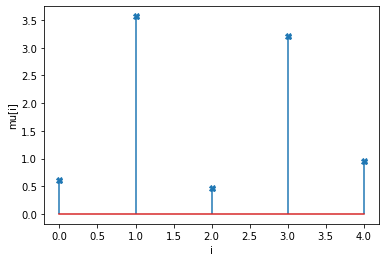

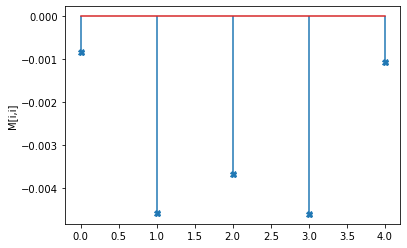

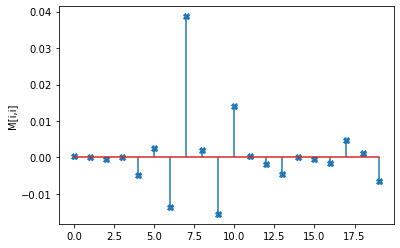

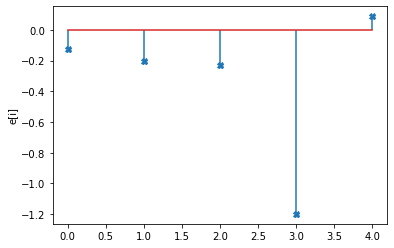

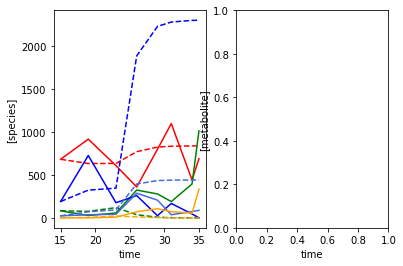

In [112]:
# Read in data
num_species=5

data = pd.read_csv("maria_multiomics/processed/data-top5-Q99.csv")
npert = 1
tp = [[15, 23]]

times = data.iloc[:,0].to_numpy()
print("times:\n",times)
yobs = data.drop(columns=['timepoint', 'subjectID']).to_numpy()
yobs[yobs == 0] = 1

print("data:\n",yobs)

u = get_signal_matrix(npert, tp)

# linearise
X, F = linearize_time_course_16S(yobs, times)

#print(X[:,:(X.shape[1]-1)])
X = X[:,:(X.shape[1]-1)]

import nest_asyncio
nest_asyncio.apply()
import stan

f = open("model_pert.txt", "r")
gLV_code=f.read()

obs_data_lin = {"N": num_species,
                "T": len(times)-1,   
                "Np": 1,
                "y": F,
                "x": X,
                "u": u.T,
                "sigma": 0.1,
                "tau0": 0.01,
                } 

posterior = stan.build(gLV_code, data=obs_data_lin, random_seed=1)

sample_kwargs = {"num_samples": 1000, "num_chains": 2, "num_warmup": 5000 }
#fit = posterior.sample(num_chains=2, num_samples=500, num_warmup=10000, adapt={'delta':0.99})
fit = posterior.sample(**sample_kwargs);

#print(fit)

df = fit.to_frame()
#print(df.describe().T)
#print(df.head())

post1 = df[df.columns[7:]][0:500].to_numpy()
post2 = df[df.columns[7:]][500:1000].to_numpy()
#post1 = np.random.normal(size=500)
#post2 = np.random.normal(size=500)
Rhat = get_Rhat(500, post1, post2)
print("Rhat:", Rhat)
istart = 0
iend = 2000

# plot the fit using median values of parameters

post1 = df[df.columns[7:]][0:iend].to_numpy()
est = np.median(post1,axis=0)

mu_h, M_h, E_h = extract_gLV_pars(est, num_species, e=True)

    
print_params(mu=mu_h, M=M_h, e=E_h)

init_species = yobs[0,:]

# make the plot and comparison
predictor = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     num_perturbations=1,
                     M=M_h,
                     mu=mu_h,
                     epsilon=E_h)
yobs_h, sobs_h, _, _, _, _ = predictor.simulate(times=times, sy0=np.hstack((init_species, init_metabolites)), tp=tp)

## PLOT RESULTS
# plot comparison of simulated and predicted timeseries
plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, times)
